# Initial eda for Postmates project
- import data
- check and adjust data types
- add any new cols (ex. time to deliver)
- summarize dataset using pandas profiling
### What would I want to know about New York?
- Daily deliveries
- Weekly, Daily, Demand Fluctuation
- Time to Order and Distribution of times around the mean
- Where are people ordering
- Where are we making the most money? avg. order price, avg. home cost in vascininity
- what merchants get the most traffic
- who's ordering the most
- when are people ordering meals



## Questions:
1. when_the_delivery_started means when the postmate received the call or when they were picking that up from a restaurant

In [566]:
root_path = '/Users/ginariddle/Desktop/g.school/my_projects/Jumpman23' 
source = 'src'   
data = 'data'  

import os   
import math  
import warnings
import numpy as np
import pandas as pd 
import seaborn as sns 
import pandas_profiling 
from uszipcode import Zipcode
import matplotlib.pyplot as plt
from uszipcode import SearchEngine  

from geopy.distance import distance
from datetime import datetime
import googlemaps
import gmaps

os.chdir(os.path.join(root_path,source))
from functions import (get_loc_data,
                       change_to_timedelta,
                       df_clean,
                       df_preprocess)
from lists import mode_dict, df_final_cols,df_delivery_cols

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
os.chdir(root_path)
with open('data/api_key.txt') as f:
    api_key = f.readline()

In [2]:
googlem = googlemaps.Client(key=api_key)
gmaps.configure(api_key=api_key)

new_york_coordinates = (40.75, -74.00)

In [241]:
gmaps.figure(center=new_york_coordinates, zoom_level=8,display_toolbar=True)

Figure(layout=FigureLayout(height='420px'))

### Original DF Cleanup

In [3]:
# import data
df = pd.read_csv('data/analyze_me.csv')
# Initial preprocessing (adds cols and changes datatypes)
df = df_preprocess(df)
# Cleans preprocessed df and preps for df_final 
df = df_clean(df)

# df.to_pickle(root_path,data,'df_final.pickle')

## DF_Final (Item lvl detail)

In [528]:
df_final = pd.read_pickle('data/df_final.pickle')

values = {'place_category':'None',
          'median_income':0,
          'median_home_value':0,
          'pop_density':0,
          'how_long_it_took_to_order':0,
          'time_start_to_pickup':0,
          'time_pickup_arrival_to_depart':0,
          'time_pickup_depart_to_dropoff':0,
          'when_the_Jumpman_arrived_at_pickup':pd.Timestamp(0),
          'when_the_Jumpman_left_pickup':pd.Timestamp(0)}

df_final_incorrect = df_final.copy()
df_final = df_final.fillna(value=values)

### Dropoff times
- time from pickup depart to dropoff
- expected time
- avg difference

In [1010]:
df_delivery = df_final.groupby(df_delivery_cols)[['item_quantity']].sum().reset_index().replace(0,np.nan)
df_delivery_incorrect = df_final_incorrect.groupby(df_delivery_cols)[['item_quantity']].sum().reset_index()
df_delivery.to_pickle(os.path.join(root_path,data,'df_delivery.pickle'))

# What deliveries to exclude from high lvl metrics

10


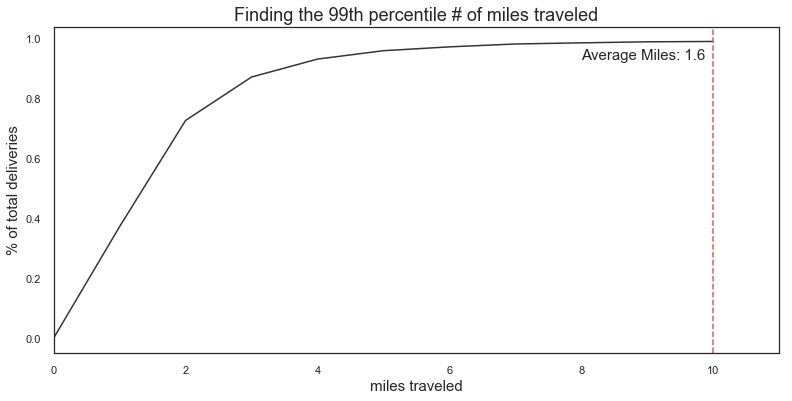

In [1097]:
fig,ax = plt.subplots(figsize=(13,6))
y = []
means = []
n = 0
y_val = 0
mean_miles = 0
y.append(y_val)
means.append(mean_miles)
while y_val <.99:
    n += 1
    y_val = df_delivery.query(f'distance_traveled < {n}').shape[0]/(df_delivery.shape[0])
    mean_miles = round(df_delivery.query(f'distance_traveled < {n}')['distance_traveled'].mean(),2)
    y.append(y_val)
    means.append(mean_miles)
plt.plot(range(n+1),y,color='black',alpha=.8)
plt.xlabel('miles traveled',fontsize=15)
plt.xlim(0,n+1)
plt.axvline(n,color='r',linestyle='--')
plt.ylabel('% of total deliveries',fontsize=15)
plt.title('Finding the 99th percentile # of miles traveled',fontsize=18)
plt.text(n-2,y[-1]-.059,f"Average Miles: {means[-1]}",horizontalalignment='left',fontsize=15)

print(n)

df_delivery_lt_11 = df_delivery.query(f'distance_traveled < {n}')


Text(0.5, 1.0, 'Change in Avg. Delivery Distance')

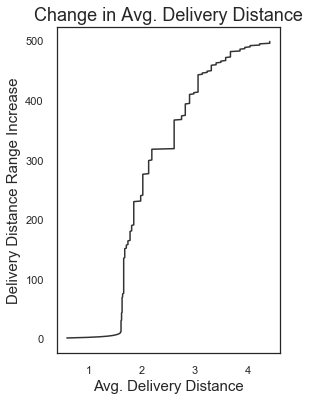

In [1117]:
fig,ax = plt.subplots(figsize=(4,6))
means = []
for i in range(500):
    mean_miles = round(df_delivery.query(f'distance_traveled < {i}')['distance_traveled'].mean(),2)
    means.append(mean_miles)
plt.plot(means,range(500),color='black',alpha=.8)
plt.ylabel('Delivery Distance Range Increase',fontsize=15)
plt.xlabel('Avg. Delivery Distance',fontsize=15)
plt.title('Change in Avg. Delivery Distance',fontsize=18)

In [1181]:
avg_time_start_to_pickup = df_delivery_lt_11.query('time_start_to_pickup > 0')['time_start_to_pickup'].mean()
avg_time_pickup_arrival_to_depart = df_delivery_lt_11[df_delivery_lt_11['time_pickup_arrival_to_depart'] > 0]['time_pickup_arrival_to_depart'].mean()
avg_time_pickup_dropoff = df_delivery_lt_11[df_delivery_lt_11['time_pickup_depart_to_dropoff'] > 0]['time_pickup_depart_to_dropoff'].mean()
avg_exp_time_pickup_dropoff = df_delivery_lt_11[df_delivery_lt_11['exp_duration'] > 0]['exp_duration'].mean()
print('Avg distance from pickup to drop: \t\t', round(df_delivery_lt_11['distance_traveled'].mean(),3),'\t',round(df_delivery_lt_11['distance_traveled'].mean(),3))
print('Avg time start to pickup: \t\t\t',round(avg_time_start_to_pickup,2))
print('Avg time pickup arrival to depart: \t\t',round(avg_time_pickup_arrival_to_depart,2))
print('Avg time from pickup depart to drop: \t\t',round(avg_time_pickup_dropoff,2))
print('Avg expected time from pickup depart to drop: \t',round(avg_exp_time_pickup_dropoff,2))
print('Avg time diff from pickup depart to drop: \t',round(avg_time_pickup_dropoff - avg_exp_time_pickup_dropoff,2))
print('Avg delivery time: \t\t\t\t',round(avg_time_start_to_pickup+avg_time_pickup_arrival_to_depart+avg_time_pickup_dropoff,2))

Avg distance from pickup to drop: 		 1.601 	 1.601
Avg time start to pickup: 			 14.18
Avg time pickup arrival to depart: 		 17.75
Avg time from pickup depart to drop: 		 13.56
Avg expected time from pickup depart to drop: 	 10.95
Avg time diff from pickup depart to drop: 	 2.61
Avg delivery time: 				 45.49


In [980]:

df_delivery_times = df_delivery[['total_time_to_deliver',
             'time_start_to_pickup',
             'time_pickup_arrival_to_depart',
             'time_pickup_depart_to_dropoff']]

In [983]:
df_delivery_times['calulated_total_time_to_deliver'] = df_delivery_times['time_start_to_pickup']+\
    df_delivery_times['time_pickup_arrival_to_depart']+\
    df_delivery_times['time_pickup_depart_to_dropoff']

df_delivery_times['total_time_delta'] = df_delivery_times['total_time_to_deliver']-\
                                        df_delivery_times['calulated_total_time_to_deliver']

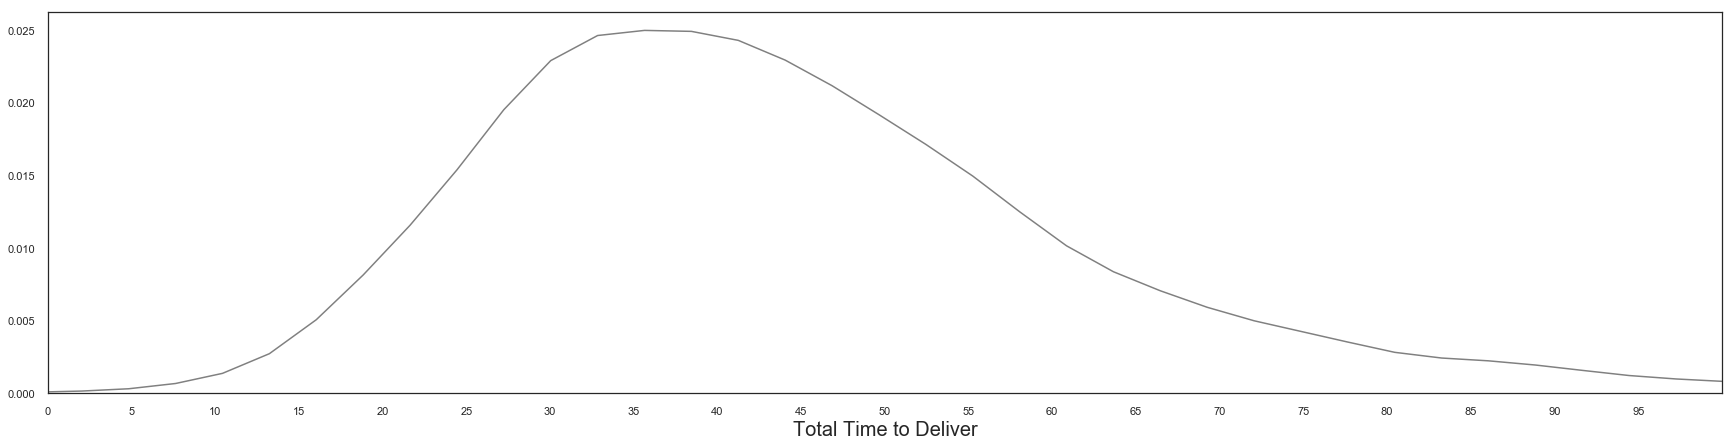

In [1398]:
fig,ax = plt.subplots(figsize=(30,7))
sns.distplot(df_delivery_lt_11['total_time_to_deliver'],hist=False,color='grey')
ax.set_xlim(0,100)
ax.set_xlabel('Total Time to Deliver',fontsize=20)
ax.set_xticks(list(range(100))[::5])
plt.rc('xtick',labelsize=15)
ax.axvline()

In [1369]:
np.linspace(0,10,50)

array([ 0.        ,  0.20408163,  0.40816327,  0.6122449 ,  0.81632653,
        1.02040816,  1.2244898 ,  1.42857143,  1.63265306,  1.83673469,
        2.04081633,  2.24489796,  2.44897959,  2.65306122,  2.85714286,
        3.06122449,  3.26530612,  3.46938776,  3.67346939,  3.87755102,
        4.08163265,  4.28571429,  4.48979592,  4.69387755,  4.89795918,
        5.10204082,  5.30612245,  5.51020408,  5.71428571,  5.91836735,
        6.12244898,  6.32653061,  6.53061224,  6.73469388,  6.93877551,
        7.14285714,  7.34693878,  7.55102041,  7.75510204,  7.95918367,
        8.16326531,  8.36734694,  8.57142857,  8.7755102 ,  8.97959184,
        9.18367347,  9.3877551 ,  9.59183673,  9.79591837, 10.        ])

In [1650]:
# for i in np.linspace(0,10,100):
#     print(i,df_delivery_lt_11['distance_traveled'].gt(i).mean())

(0, 6)

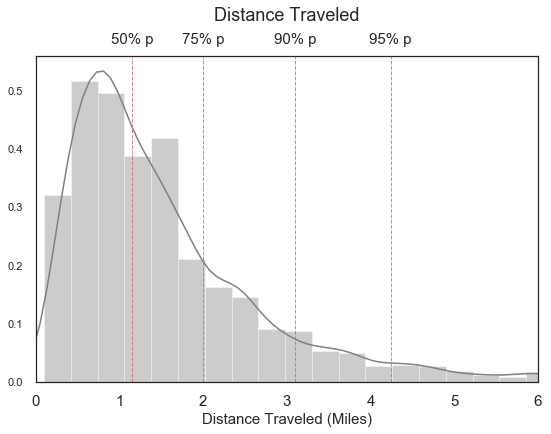

In [1416]:
percentiles = ['50%','75%','90%','95%']
miles = [1.15,2,3.1,4.24]
sns.set(style="white", palette="muted", color_codes=True)
fig,ax = plt.subplots(figsize=(9,6))
sns.distplot(df_delivery_lt_11['distance_traveled'],bins=30,color='grey')
plt.text(3,.62,'Distance Traveled',fontsize=18,horizontalalignment='center')
plt.xlabel('Distance Traveled (Miles)',fontsize=15)
ax.set_xticks(range(7))
plt.xticks(fontsize=15)

for i in range(len(miles)):
    plt.axvline(miles[i],linewidth=1,linestyle='--',alpha=.75,color='r')
    plt.text(miles[i],.58,percentiles[i] + ' p',horizontalalignment='center',fontsize=15)
    
plt.xlim(0,6)

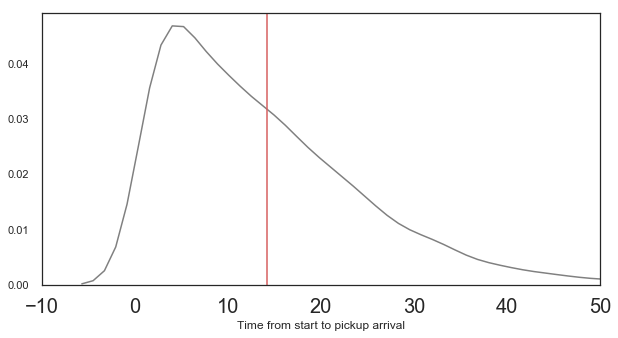

In [1194]:

# percentiles=['50%','75%','95%','99%']
# times = [11,20,35,49]
fig,ax = plt.subplots(figsize=(10,5))
sns.distplot(df_delivery_lt_11.query('time_start_to_pickup > 0')['time_start_to_pickup'],
             bins=30,color='grey',hist=False,ax=ax)
# ax.text(avg_time_start_to_pickup,.002,f'Avg time: {round(avg_time_start_to_pickup)} min',fontsize=15,horizontalalignment='center')
ax.set_xlabel('Time from start to pickup arrival')
plt.xlim(-10,50)
plt.axvline(avg_time_start_to_pickup,linewidth=1.5,alpha=1,color='r')
  


In [1651]:
# for i in np.linspace(0,50,101):
#     print(round(i,2),round(df_delivery_lt_11['time_pickup_arrival_to_depart'].dropna().gt(i).mean(),2))

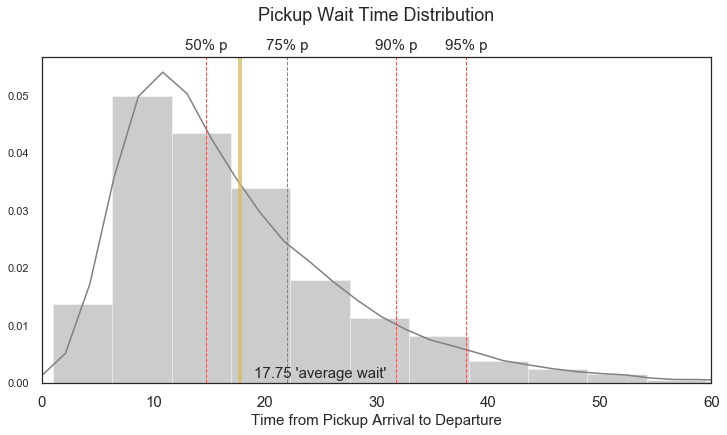

In [1649]:
percentiles = ['50%','75%','90%','95%']
miles = [14.75,22,31.75,38]
fig,ax = plt.subplots(figsize=(12,6))
sns.distplot(df_delivery_lt_11['time_pickup_arrival_to_depart'],
             bins=50,color='grey',ax=ax)
# ax.text(avg_time_pickup_arrival_to_depart,.002,f'Avg time: {round(avg_time_pickup_arrival_to_depart)} min',fontsize=15,horizontalalignment='center')
ax.set_xlabel('Time from Pickup Arrival to Departure')
plt.xlim(0,60)
plt.axvline(avg_time_pickup_arrival_to_depart,linewidth=4,alpha=.75,color='y')
plt.text(30,.063,'Pickup Wait Time Distribution',fontsize=18,horizontalalignment='center')
plt.text(19,.001,f"{round(avg_time_pickup_arrival_to_depart,2)} 'average wait'",fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('Time from Pickup Arrival to Departure',fontsize=15)

for i in range(len(miles)):
    plt.axvline(miles[i],linewidth=1,linestyle='--',alpha=1,color='r')
    plt.text(miles[i],.058,percentiles[i] + ' p',horizontalalignment='center',fontsize=15)
    
    
  

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
rf = RandomForestRegressor()
df_delivery_lt_11.dropna().shape

In [1598]:
values = {'item_quantity':1,
          'median_income':df_delivery_lt_11['median_income'].mean(),
          'median_home_value':df_delivery_lt_11['median_home_value'].mean(),
          'pop':df_delivery_lt_11['pop'].mean(),
          'pop_density':df_delivery_lt_11['pop_density'].mean(),
          'how_long_it_took_to_order':df_delivery_lt_11['how_long_it_took_to_order'].mean()}

features_df = df_delivery_lt_11.drop(['when_the_delivery_started',
#                         'when_the_Jumpman_arrived_at_pickup',
                        'when_the_Jumpman_left_pickup',
                        'when_the_Jumpman_arrived_at_dropoff',
                        'when_the_Jumpman_arrived_at_pickup',
                        'total_time_to_deliver',
                        'time_pickup_depart_to_dropoff',
                        'time_start_to_pickup','delivery_id','customer_id'],axis=1)
features_df = features_df.fillna(value=values).dropna()
features_df = pd.get_dummies(features_df)

In [1599]:
np.random.seed(3)
y = features_df['time_pickup_arrival_to_depart']
X = features_df.drop('time_pickup_arrival_to_depart',axis=1)
x_train,x_test,y_train,y_test = train_test_split(X,y,random_state=3)
rf.fit(x_train,y_train)
y_pred = rf.predict(x_test)

mean_absolute_error(y_test,y_pred), mean_absolute_error(y_test,[y_train.mean() for i in range(len(y_test))])

(7.309936766034326, 8.185288369861798)

In [1600]:
important_features = pd.DataFrame(rf.feature_importances_,
                                            index=X.columns).sort_values(0,ascending=False).iloc[:20]

In [1601]:
important_features

0
jumpman_id                        0.137550
dropoff_lon                       0.102490
day                               0.087033
place_category_Grocery Store      0.069980
dropoff_lat                       0.048601
how_long_it_took_to_order         0.047993
exp_duration                      0.041903
distance_traveled                 0.034669
item_quantity                     0.033620
weekday_Friday                    0.023218
pickup_lat                        0.022402
pickup_lon                        0.021844
pickup_place_Momofuku Noodle Bar  0.017991
pickup_place_Shake Shack          0.015945
median_home_value                 0.012261
zipcodes_10011                    0.010519
pop_density                       0.010347
weekday_Saturday                  0.007389
land_area_in_sqmi                 0.007089
median_income                     0.006654

Text(0.5, 0, 'Relative Importance in Predicting Feature')

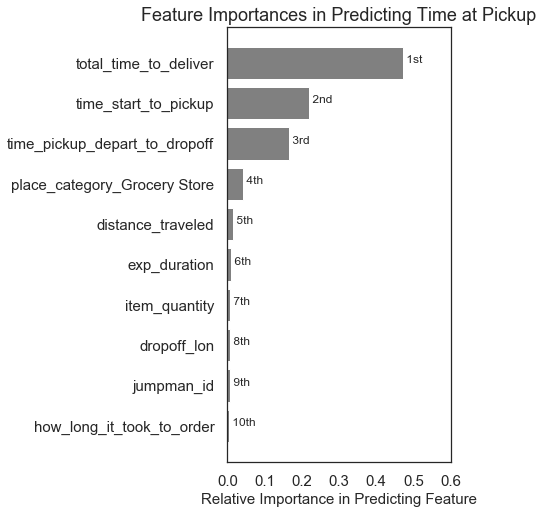

In [1535]:
endings = ['st','nd','rd','th','th','th','th','th','th','th']
fig,ax = plt.subplots(figsize=(4,8))
y = important_features[0].values.flatten()
x = list(range(important_features.shape[0]))
plt.barh(x,y,color='grey')
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_yticks(x)
ax.set_xlim(0,.6)
plt.xticks(fontsize=15)
ax.set_yticklabels(important_features['index'],fontsize=15)
for i in range(1,11):
    plt.text(y[i-1],x[i-1],f" {i}{endings[i-1]}")
plt.title('Feature Importances in Predicting Time at Pickup',fontsize=18)
plt.xlabel('Relative Importance in Predicting Feature',fontsize=15)

In [1542]:
df_delivery_lt_11.query("place_category== 'Grocery Store'")['time_pickup_arrival_to_depart'].mean()

40.252252252252255

In [1585]:
df_delivery_lt_11.query("place_category != 'Grocery Store'")['time_pickup_arrival_to_depart']

delivery_id  customer_id  jumpman_id vehicle_type  \
0         1271706        66556      154943          car   
1         1271751       104131      124897      bicycle   
2         1271867       121706      124897      bicycle   
3         1272279       304449      112830      bicycle   
4         1272303       107621      127812      bicycle   
5         1272363       315298       67430      bicycle   
6         1272372        55334       99219      bicycle   
8         1272439       354016       99219      bicycle   
9         1272451       103329       30743      bicycle   
10        1272468       183564       60761      bicycle   
11        1272470       270525      112646      bicycle   
12        1272494       346280      143261      bicycle   
13        1272507        91981      103666      bicycle   
14        1272543        86172       43955      bicycle   
15        1272595       288777      103666      bicycle   
16        1272603        82691      142394      bicycle   
17        1272605        54081      122309      bicycle   
18        1272612        81591       84093      bicycle   
19        1272654       247261      137891      bicycle   
20        1272678        44759       67430      bicycle   
21        1272701        81085      112646      bicycle   
22        1272737       180618      143261      bicycle   
23        1272790       230535       73175      bicycle   
24        1272824       284087       23359      bicycle   
26        1272849        70832      149651      bicycle   
27        1272853       111939       67430      bicycle   
28        1272862       297592       60761      bicycle   
29        1272867       141449      143261      bicycle   
30        1272896       354948       43955      bicycle   
31        1272936       174148      137891      bicycle   
...           ...          ...         ...          ...   
5183      1489715       252342       38597      bicycle   
5184      1489727       141550      142394      bicycle   
5185      1489740        97346       22502      bicycle   
5186      1489747       251817       65763      bicycle   
5187      1490002       393765       65763      bicycle   
5188      1490031        35432      142140          car   
5189      1490047       102691       72941      bicycle   
5190      1490084       252664      151073      bicycle   
5191      1490119        61128       67899          car   
5192      1490183       385368       17402      bicycle   
5193      1490188       166368      174143   motorcycle   
5194      1490287        49246      156557          car   
5195      1490295        54630      108004      bicycle   
5196      1490384       186473      123581      bicycle   
5197      1490419       140501       90681      bicycle   
5198      1490466       155689       17402      bicycle   
5199      1490735       160543      152741          car   
5201      1490771       140854       72480          car   
5202      1490779        59161      170602      bicycle   
5203      1490802        70541      161459      bicycle   
5204      1490829       400897       53095      bicycle   
5205      1490865        62730      151073      bicycle   
5206      1490893       295078      157975      bicycle   
5207      1491029       405547      142394      bicycle   
5208      1491090       276192      179183          car   
5209      1491110       216932      137090      bicycle   
5210      1491144        54851      104533      bicycle   
5211      1491147       320359      172130       walker   
5212      1491341       229946       59348       walker   
5213      1491424       391367      172130       walker   

                                pickup_place     place_category zipcodes  \
0                               CVS Pharmacy               None    10001   
1                                Duane Reade         Drug Store    10065   
2                                 McDonald's          Fast Food    10018   
3                         Friend of a Farme

In [1477]:
important_features = important_features.reset_index()

In [1418]:
df_delivery_lt_11.head(1)

delivery_id  customer_id  jumpman_id vehicle_type  pickup_place  \
0      1271706        66556      154943          car  CVS Pharmacy   

  place_category zipcodes      city  pickup_lat  pickup_lon  dropoff_lat  \
0           None    10001  New York   40.744157  -73.991987    40.744079   

   dropoff_lon  median_income  median_home_value  day    weekday      pop  \
0   -73.991519        81671.0           650200.0    1  Wednesday  21102.0   

   pop_density  land_area_in_sqmi state  how_long_it_took_to_order  \
0      33959.0               0.62    NY                        NaN   

   total_time_to_deliver  time_start_to_pickup  time_pickup_arrival_to_depart  \
0                   22.0                   NaN                            NaN   

   time_pickup_depart_to_dropoff  exp_duration  distance_traveled  \
0                            NaN           4.0                0.4   

   when_the_delivery_started when_the_Jumpman_arrived_at_pickup  \
0 2014-10-01 00:07:58.632482                         1970-01-01   

  when_the_Jumpman_left_pickup when_the_Jumpman_arrived_at_dropoff  \
0                   1970-01-01          2014-10-01 00:30:21.109149   

   item_quantity  
0            NaN

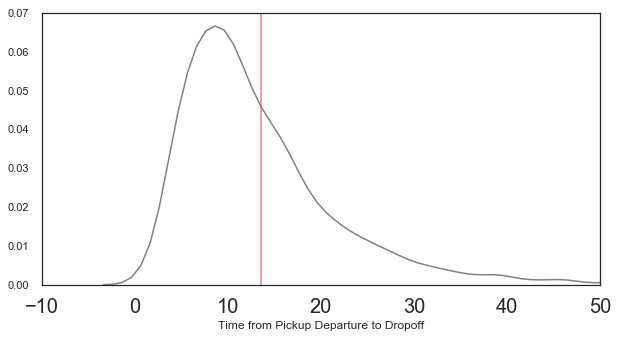

In [1192]:
# percentiles=['50%','75%','95%','99%']
# times = [15,23,39,56]
fig,ax = plt.subplots(figsize=(10,5))
sns.distplot(df_delivery_lt_11['time_pickup_depart_to_dropoff'],
             bins=30,color='grey',hist=False,ax=ax)
# ax.text(avg_time_pickup_dropoff,.002,f'Avg time: {round(avg_time_pickup_dropoff)} min',
#         fontsize=15,horizontalalignment='center')
ax.set_xlabel('Time from Pickup Departure to Dropoff')
plt.xlim(-10,50)
plt.axvline(avg_time_pickup_dropoff,linewidth=1.5,alpha=.75,color='r')

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.]),
 <a list of 7 Text xticklabel objects>)

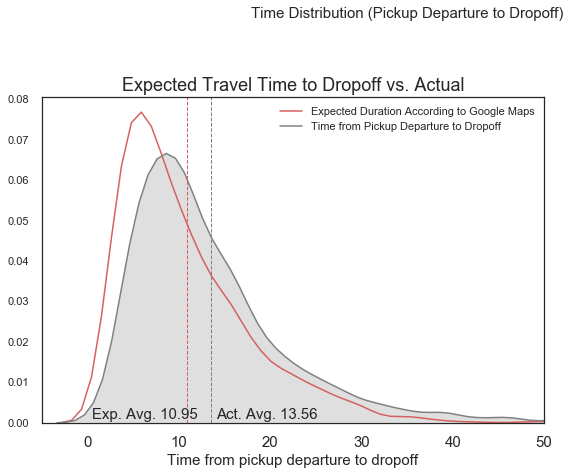

In [1413]:

percentiles=['50%','75%','95%','99%']
times = [15,23,39,56]
fig,ax = plt.subplots(figsize=(9,6))
sns.kdeplot(df_delivery_lt_11['exp_duration'],c='r',label='Expected Duration According to Google Maps')
sns.kdeplot(df_delivery_lt_11['time_pickup_depart_to_dropoff'],
            c='grey',
            shade=True,
            label = 'Time from Pickup Departure to Dropoff')
plt.text(35,.1,'Time Distribution (Pickup Departure to Dropoff)',fontsize=15,horizontalalignment='center')
plt.xlabel('Time from pickup departure to dropoff',fontsize=15)
plt.xlim(-5,50)
# for i in range(len(times)):
#     plt.axvline(times[i],linewidth=.75,linestyle='--',alpha=.75,color='r')
#     plt.text(times[i],.077,percentiles[i] + ' p',horizontalalignment='center',fontsize=13)
plt.axvline(avg_exp_time_pickup_dropoff,color='r',linestyle='--',linewidth=1)
plt.axvline(avg_time_pickup_dropoff,color='grey',linestyle='--',linewidth=1)
plt.text(.5,
         .001,
         f"Exp. Avg. {round(avg_exp_time_pickup_dropoff,2)}",
         horizontalalignment='left',fontsize=15)
plt.text(avg_time_pickup_dropoff+.5,
         .001,
         f"Act. Avg. {round(avg_time_pickup_dropoff,2)}",
         horizontalalignment='left',fontsize=15)
plt.title('Expected Travel Time to Dropoff vs. Actual',fontsize=18)
plt.xticks(fontsize=15)

In [1316]:
duration_error = df_delivery_lt_11['time_pickup_depart_to_dropoff']\
    .sub(df_delivery_lt_11['exp_duration']).dropna()

duration_error_minus5 = duration_error.lt(-5).mean()
duration_error_minus5_0 = duration_error.between(-5,0).mean()
duration_error_0_7 = duration_error.between(0.00001,7).mean()
duration_error_7plus = duration_error.gt(7).mean()

In [1313]:
duration_error_minus5,duration_error_minus5_0,duration_error_0_5,duration_error_5plus

(0.0574468085106383,
 0.26893617021276595,
 0.5385106382978724,
 0.1351063829787234)

(array([-10.,  -5.,   0.,   5.,  10.,  15.,  20.]),
 <a list of 7 Text xticklabel objects>)

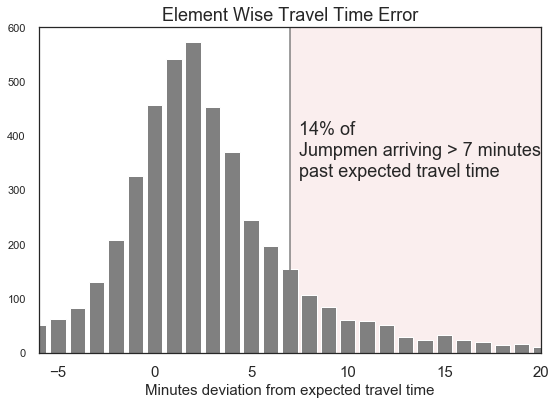

In [1420]:
fig,ax = plt.subplots(figsize=(9,6))
ax.axvspan(7, 30, alpha=.1, color='r')
duration_error_value_counts = df_delivery_lt_11['time_pickup_depart_to_dropoff']\
    .sub(df_delivery_lt_11['exp_duration'])\
    .dropna().value_counts().sort_index()
x = duration_error_value_counts.index
y = duration_error_value_counts.values
plt.bar(x,y,color='grey')
plt.xlim(-6,20)
plt.axvline(7,color='grey')
plt.xlabel('Minutes deviation from expected travel time',fontsize=15)
plt.text(7.5,325,f'14% of \nJumpmen arriving > 7 minutes \npast expected travel time',fontsize=18)
# ax.axvspan(-10, -5, alpha=0.5, color='red')
plt.title('Element Wise Travel Time Error',fontsize=18)
plt.xticks(fontsize=15)


In [537]:
df_delivery = pd.read_pickle('data/df_delivery.pickle')

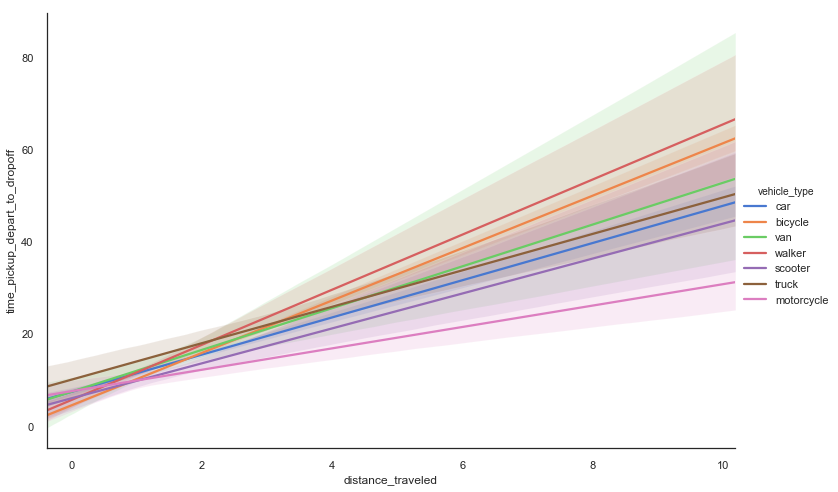

In [1672]:
mode = 'walker'
df_distance = df_delivery_lt_11\
    .query(f"vehicle_type == '{mode}'")[['distance_traveled',
                                         'time_pickup_depart_to_dropoff',
                                         'vehicle_type']]
sns.lmplot('distance_traveled','time_pickup_depart_to_dropoff',height=7,aspect=1.5,hue='vehicle_type',data = df_delivery_lt_11,scatter=False)
# plt.xlim(-2,10)
# plt.ylim(-10,100)

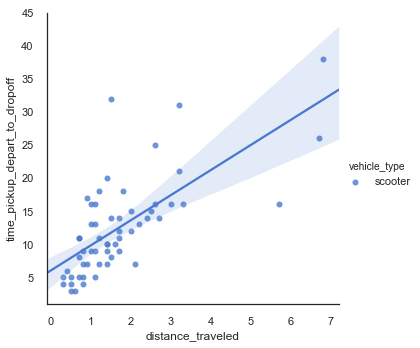

In [1652]:
mode = 'scooter'
df_distance = df_delivery.query('distance_traveled < 12').query(f"vehicle_type == '{mode}'")[['distance_traveled','time_pickup_depart_to_dropoff','vehicle_type']]

sns.lmplot('distance_traveled','time_pickup_depart_to_dropoff',hue='vehicle_type',data = df_distance)
# plt.xlim(-2,10)
# plt.ylim(-10,100)

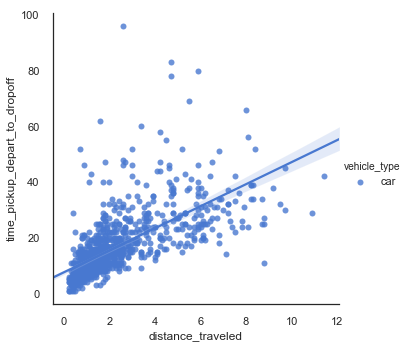

In [1654]:
mode = 'car'
df_distance = df_delivery.query('distance_traveled < 12')\
            .query(f"vehicle_type == '{mode}'")[['distance_traveled',
                                                 'time_pickup_depart_to_dropoff',
                                                 'vehicle_type']]

sns.lmplot('distance_traveled','time_pickup_depart_to_dropoff',hue='vehicle_type',data = df_distance)
# plt.xlim(-2,10)
# plt.ylim(-10,100)

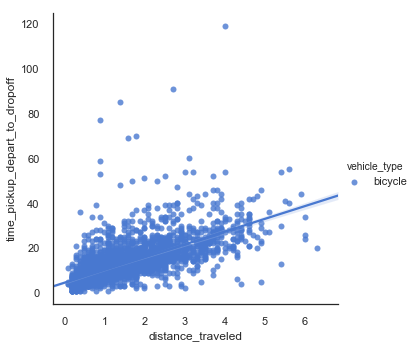

In [1673]:
mode = 'bicycle'
df_distance = df_delivery_lt_11\
            .query(f"vehicle_type == '{mode}'")[['distance_traveled',
                                                 'time_pickup_depart_to_dropoff',
                                                 'vehicle_type']]

sns.lmplot('distance_traveled','time_pickup_depart_to_dropoff',hue='vehicle_type',data = df_distance)
# plt.xlim(-2,10)
# plt.ylim(-10,100)

In [1681]:
transport_modes = df_delivery_lt_11['vehicle_type'].value_counts(normalize=True).round(3)

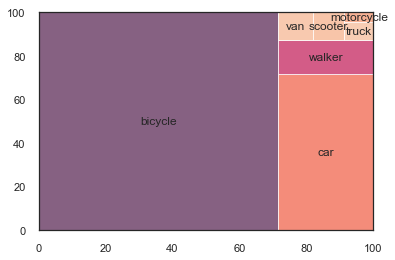

In [1683]:
import squarify
sizes = transport_modes.values
labels = transport_modes.index
# df_delivery_lt_11
squarify.plot(sizes=sizes, label=labels, alpha=.7 )


## Order

In [836]:
order_df = df_delivery[['how_long_it_took_to_order','item_quantity']].dropna()

Text(10.5, 0.73, '80% of orders placed within 10 minutes')

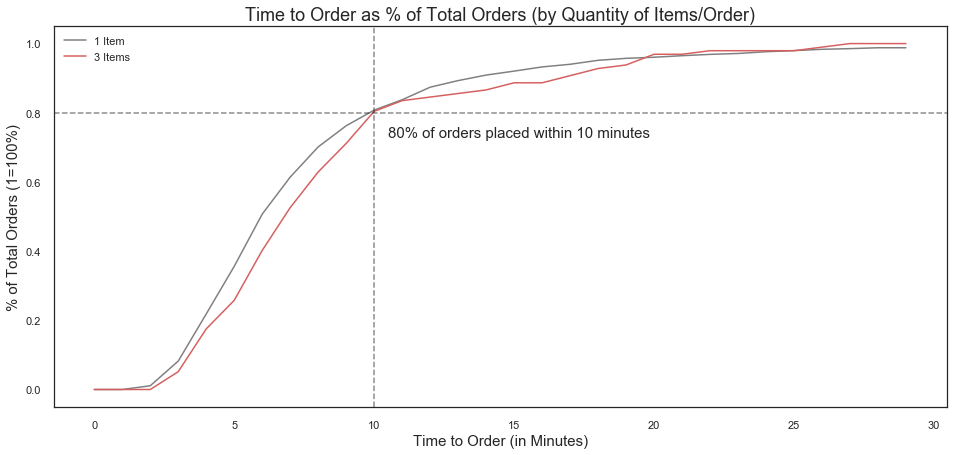

In [972]:
not_nan_mask = ~df_delivery['how_long_it_took_to_order'].isna()
y_3_mask = df_delivery['item_quantity']==3
y_mask = df_delivery['item_quantity']==1
colors = ['grey','r']
x = range(30)
y = []
y_3 = []
y_name = ['1 Item','3 Items']
y_list = [y,y_3]
for i in range(30):
    y.append(df_delivery[not_nan_mask][y_mask]['how_long_it_took_to_order'].lt(i).mean())
    y_3.append(df_delivery[not_nan_mask][y_3_mask]['how_long_it_took_to_order'].lt(i).mean())

    
plt.figure(figsize=(16,7))
for y,name,c in zip(y_list,y_name,colors):
    plt.plot(x,y,label=name,color=c)
plt.axvline(10,color='k',alpha=.5,linestyle='--')
plt.axhline(.8,color='k',alpha=.5,linestyle='--')
plt.legend()
plt.xlabel('Time to Order (in Minutes)',fontsize=15)
plt.ylabel('% of Total Orders (1=100%)',fontsize=15)
plt.title('Time to Order as % of Total Orders (by Quantity of Items/Order)',fontsize=18)
plt.text(10.5,.73,'80% of orders placed within 10 minutes',fontsize=15)

In [573]:
df_delivery['how_long_it_took_to_order'] = df_delivery['how_long_it_took_to_order'][not_nan_mask]

In [934]:
order_time_df = pd.DataFrame(np.asarray([x,y,count_time_by_place_cat.astype(int)]).T,columns=['x','y','hue'])

In [966]:
top_merchants_categories = df_delivery['place_category'].value_counts(normalize=True).round(2)



None                     0.16
Italian                  0.08
Burger                   0.08
American                 0.07
Japanese                 0.06
Dessert                  0.05
Chinese                  0.05
Sushi                    0.04
Salad                    0.04
Mexican                  0.03
Grocery Store            0.02
Bakery                   0.02
BBQ                      0.02
Pizza                    0.02
Juice Bar                0.02
Indian                   0.02
Fast Food                0.02
Donut                    0.01
Seafood                  0.01
Drug Store               0.01
Mediterranean            0.01
Vegetarian               0.01
Coffee                   0.01
Middle Eastern           0.01
Deli                     0.01
Ice Cream                0.01
Gluten-Free              0.01
Breakfast                0.01
Shop                     0.01
South American           0.01
Thai                     0.01
Steak                    0.01
French                   0.00
Southern  

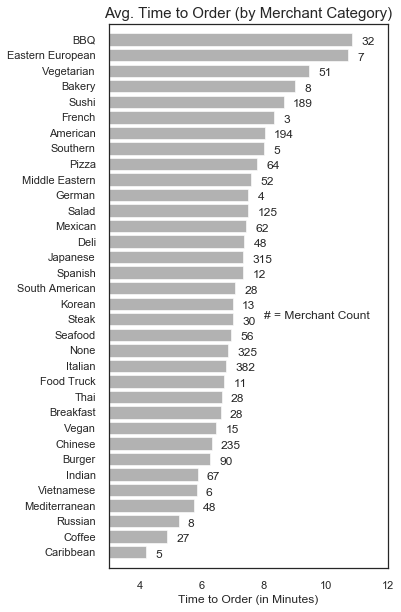

In [957]:
fig,ax = plt.subplots(figsize=(5,10))
time_by_place_cat = df_delivery.groupby('place_category')['how_long_it_took_to_order']\
                    .agg(['count','mean'])\
                    .query('count >2')\
                    .sort_values('mean',ascending=True)

avg_time_by_place_cat = time_by_place_cat['mean']
count_time_by_place_cat = time_by_place_cat['count']

x = avg_time_by_place_cat.values
y = [i for i in range(len(avg_time_by_place_cat))]
sns.barplot('x','y',data=order_time_df,color='grey',orient='h',alpha=.6)
for i in range(len(count_time_by_place_cat)):
    plt.text(avg_time_by_place_cat[i]+.3,y[i]-.35,count_time_by_place_cat[i])
plt.text(8,15,'# = Merchant Count',withdash=True)
ax.set_yticks(y)
ax.set_yticklabels(avg_time_by_place_cat.index)
plt.xlim(3,12)
plt.ylabel('')
plt.ylim(-1,34)
ax.set_xlabel('Time to Order (in Minutes)')
plt.title('Avg. Time to Order (by Merchant Category)',fontsize=15)
plt.show()

In [164]:
df_delivery['how_long_it_took_to_order'].mean()

Timedelta('0 days 00:07:41.034654')

## Delivery
- time to pickup
- pickup arrival to pickup depart
- pickup depart to drop-off
- order distance
- other: order distance by mode of transport


In [159]:
application_set = df_final[df_final['how_long_it_took_to_order'].isna()]
training_set = df_final[~df_final['how_long_it_took_to_order'].isna()]

In [221]:
avg_time_to_pickup = df_delivery['time_start_to_pickup'].astype('timedelta64[m]').mean()
avg_time_pickup_arrival_to_depart = df_delivery['time_pickup_arrival_to_depart'].astype('timedelta64[m]').mean()
avg_time_pickup_depart_to_dropoff = df_delivery['time_pickup_depart_to_dropoff'].astype('timedelta64[m]').mean()

In [224]:
avg_time_pickup_depart_to_dropoff

13.264090177133655

In [ ]:
def convert_to_mins(series):
    return series.astype('timedelta64[m]')

In [37]:
[a for a,b in x][::2]

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]

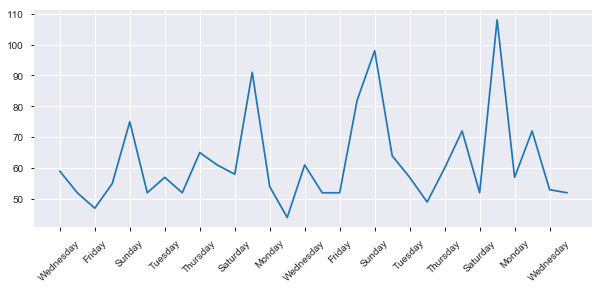

In [45]:
y = df_delivery.groupby(['day','weekday'])['delivery_id'].count().values
x = df_delivery.groupby(['day','weekday'])['delivery_id'].count().index



fig,ax = plt.subplots(figsize=(10,4))
ax.plot([a for a,b in x],y)
ax.set_xticks([a for a,b in x][::2])
ax.set_xticklabels([b for a,b in x][::2],rotation=45)
plt.show()

In [20]:
df.profile_report(style={'full_width':True})

In [467]:
application_set = df_final[df_final['how_long_it_took_to_order'].isna()]
training_set = df_final[~df_final['how_long_it_took_to_order'].isna()]

In [468]:
def preprocess_data(dataset):
    cols_important = ['total_time_to_deliver', 'time_pickup_arrival_to_depart',
       'time_pickup_depart_to_dropoff', 'time_start_to_pickup', 'dropoff_lon', 'day', 'dropoff_lat', 'pickup_lat',
       'pickup_lon']
    y = dataset['how_long_it_took_to_order']
    X = dataset[cols_important]
    X = pd.get_dummies(X)
    return X, y

X,y = preprocess_data(training_set)

values = {'time_pickup_arrival_to_depart':X['time_pickup_arrival_to_depart'].mean(),
         'time_pickup_depart_to_dropoff':X['time_pickup_depart_to_dropoff'].mean(),
         'time_start_to_pickup':X['time_start_to_pickup'].mean()}

X = X.fillna(value=values)

total_time_to_deliver  time_pickup_arrival_to_depart  \
0                      60.0                      16.646389   
1                      60.0                      22.000000   
2                      24.0                      21.000000   
4                      41.0                      10.000000   
5                      40.0                       8.000000   
6                      31.0                      22.000000   
10                     46.0                       4.000000   
11                     65.0                      16.646389   
13                     39.0                      19.000000   
15                     67.0                       8.000000   
17                     76.0                      13.000000   
18                     31.0                      18.000000   
25                     51.0                       9.000000   
26                     33.0                      11.000000   
27                     44.0                      16.000000   
28                    123.0                      30.000000   
29                     42.0                      16.000000   
31                     67.0                      14.000000   
32                     38.0                      15.000000   
35                     75.0                      38.000000   
36                     59.0                      16.646389   
38                     42.0                      17.000000   
40                     42.0                      14.000000   
41                     40.0                       7.000000   
45                     43.0                       7.000000   
46                     29.0                      10.000000   
49                     47.0                      11.000000   
50                     32.0                      12.000000   
51                     57.0                      16.646389   
54                     42.0                      15.000000   
...                     ...                            ...   
5936                   44.0                      35.000000   
5937                   66.0                      32.000000   
5940                   23.0                       9.000000   
5944                   25.0                      12.000000   
5945                   59.0                      38.000000   
5946                   29.0                       8.000000   
5947                   56.0                      29.000000   
5948                   35.0                      20.000000   
5949                   31.0                      11.000000   
5950                   41.0                      15.000000   
5951                   55.0                       8.000000   
5952                   34.0                      15.000000   
5953                   33.0                      30.000000   
5955                   97.0                      38.000000   
5956                   92.0                      10.000000   
5957                   86.0                      51.000000   
5958                   49.0                      35.000000   
5959                   28.0                       8.000000   
5963                   25.0                       8.000000   
5964                   42.0                      15.000000   
5965                   32.0                      21.000000   
5968                   29.0                       6.000000   
5970                   62.0                      35.000000   
5971                   54.0                      40.000000   
5972                   84.0                      17.000000   
5973                   21.0                       6.000000   
5975                   37.0                      22.000000   
5977                   44.0                      23.000000   
5981                   25.0                      16.000000   
5982                   61.0                      25.000000   

      time_pickup_depart_to_dropoff  time_start_to_pickup  dropoff_lon  day  \
0                         13.593027             14.250089   -73.985370   26   
1  